## Creating Custom Networks
In this notebook you have to create a custom network whose architecture has been given, and use the dataset you created earlier to train and test it.

In [1]:
# Import Statements
#
# Several of the imports you will need have been added but you will need to provide the
# rest yourself; you should be able to figure out most of the imports as you go through
# the notebook since without proper imports your code will fail to run
#
# All import statements go in this block

from __future__ import division, print_function, unicode_literals
import numpy as np
import torch
import torch.nn as nn
import torch.utils.data
import torchvision.transforms as transforms
import os
from skimage import io, transform
from torch.autograd import Variable
%matplotlib inline
import matplotlib.pyplot as plt
import time

All hyper parameters go in the next block

In [2]:
batch_size = 100
num_epochs = 30
learning_rate = 0.01

### Create Custom Dataset and Loader
This is the same as part 1. Simply use the same code to create the dataset.

In [3]:
class CDATA(torch.utils.data.Dataset): 
    def __init__(self, root_dir, train, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.train = train
        
        if(self.train):
            data_dir = os.path.join(self.root_dir, 'train')
        else:
            data_dir = os.path.join(self.root_dir, 'test')

        self.mlist = list()
        
        for root, dirs, files in os.walk(data_dir):
            path = root.split(os.sep)
            lab = os.path.basename(root)
            for file in files:
                self.mlist.append(file +'LAB'+ str(ord(lab) - ord('A')))

    def __len__(self):
        return len(self.mlist)
        
    def __getitem__(self, idx):
        name = self.mlist[idx]
        file = name[:-4]
        label = int(name[-1])
        
        if(self.train):
            data_dir = os.path.join(self.root_dir, 'train')
        else:
            data_dir = os.path.join(self.root_dir, 'test')
        
        img_name = os.path.join(data_dir , chr(ord('A') + label), file)
        image = io.imread(img_name,as_grey = False)
        image = np.repeat(image[:, :,np.newaxis], 3, axis=2)
        to_pil = transforms.ToPILImage()
        image = to_pil(image)
        
        if self.transform:
            image = self.transform(image)
        return (image,label)
    
composed_transform = transforms.Compose([transforms.Scale((32,32)),transforms.ToTensor()])
train_dataset = CDATA(root_dir='./../notMNIST_small', train=True, transform=composed_transform) # Supply proper root_dir
test_dataset = CDATA(root_dir='./../notMNIST_small', train=False, transform=composed_transform) # Supply proper root_dir

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

### Creating a Custom Network
It's time to create a new custom network. This network is based on Resnet (indeed it is a resnet since it uses skip connections). The architecture of the network is provided in the diagram. It specifies the layer names, layer types as well as their parameters.
<img src="architecture.png" width=100>
[Full size image](architecture.html)

In [4]:
class CustomResnet(nn.Module): # Extend PyTorch's Module class
    def __init__(self, num_classes = 10):
        super(CustomResnet, self).__init__() # Must call super __init__()
        
        # Define the layers of the network here
        # There should be 17 total layers as evident from the diagram
        # The parameters and names for the layers are provided in the diagram
        # The variable names have to be the same as the ones in the diagram
        # Otherwise, the weights will not load
        
        self.conv1 = nn.Conv2d(3, 64, 7, stride = 2 , padding = 3 , bias = True)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace= True)
        self.maxpool = nn.MaxPool2d(3, stride=2, padding=1)
        self.lyr1conv1 = nn.Conv2d(64, 64, 3, stride = 1 , padding = 1 , bias = True)
        self.lyr1bn1 = nn.BatchNorm2d(64)
        self.lyr1relu1 = nn.ReLU(inplace= True)
        self.lyr1conv2 = nn.Conv2d(64, 64, 3, stride = 1 , padding = 1 , bias = True)
        self.lyr1bn2 = nn.BatchNorm2d(64)
        self.lyr1relu2 = nn.ReLU(inplace= True)
        self.lyr2conv1 = nn.Conv2d(64, 64, 3, stride = 1 , padding = 1 , bias = True)
        self.lyr2bn1 = nn.BatchNorm2d(64)
        self.lyr2relu1 = nn.ReLU(inplace= True)
        self.lyr2conv2 = nn.Conv2d(64, 64, 3, stride = 1 , padding = 1 , bias = True)
        self.lyr2bn2 = nn.BatchNorm2d(64)
        self.lyr2relu2 = nn.ReLU(inplace= True)
        self.fc = nn.Linear(4096, num_classes)
        
    def forward(self, x):
        # Here you have to define the forward pass
        # Make sure you take care of the skip connections
        x = self.conv1(x)
        x = self.maxpool(self.relu(self.bn1(x)))
        xbranch = self.lyr1relu1(self.lyr1bn1(self.lyr1conv1(x)))
        xbranch = self.lyr1bn2(self.lyr1conv2(x))
        x = self.lyr1relu2(x + xbranch)
        xbranch = self.lyr2relu1(self.lyr2bn1(self.lyr2conv1(x)))
        xbranch = self.lyr2bn2(self.lyr2conv2(x))
        x = self.lyr2relu2(x + xbranch)
        x = x.view(-1,4096)
        return self.fc(x)

#### Finetune on pre-trained CIFAR-100 weights
We shall now finetune our model using pretrained CIFAR-100 weights.

In [5]:
model = CustomResnet(num_classes = 100) # 100 classes since CIFAR-100 has 100 classes

# Load CIFAR-100 weights. (Download them from assignment page)
# If network was properly implemented, weights should load without any problems
model.load_state_dict(torch.load('CIFAR-100_weights')) # Supply the path to the weight file

In [6]:
# Change last layer to output 10 classes since our dataset has 10 classes
# Complete this statement. It is similar to the resnet18 case
model.fc = nn.Linear(model.fc.in_features, 10)

# Loss function and optimizers
criterion = nn.CrossEntropyLoss()# Define cross-entropy loss
optimizer =  torch.optim.Adam(model.parameters(), lr = learning_rate)# Use Adam optimizer, use learning_rate hyper parameter
if(torch.cuda.is_available()):
    model.cuda()


Let's finetune the model.

In [7]:
def train(num_epochs):
    stats = {'epoch_loss':list(),'trainacc':list(),'testacc':list()}
    
    for epoch in range(num_epochs):
        start = time.time()
        running_loss = 0
        for i, data in enumerate(train_loader):
            inputs, labels = data
            if(torch.cuda.is_available()):
                inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
            else:
                inputs, labels = Variable(inputs), Variable(labels)
           
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.data[0]

        end = time.time()
       
        print('Epoch #',epoch,'Loss per batch: ',round(running_loss/len(train_loader),2),'Time in this epoch: ',round(end-start,2))
        
        stats['epoch_loss'].append(round(running_loss/len(train_loader),2))
        
        start = time.time()
        
        print('Test')
        stats['testacc'].append(test(model, False))
        
        print('Training')
        stats['trainacc'].append(test(model, True))
    
    print('Finished Training')
    return stats

def test(model,training):
    # Write loops for testing the model on the test set
    # You should also print out the accuracy of the model
    tot = right = 0
    if(training == False):
        x = test_loader
    else:
        x = train_loader
    for data in x:
        images, labels = data
        images, labels = images.cuda(),labels.cuda()
        images, labels = Variable(images, volatile = True), Variable(labels)
        outputs = model(images)
        q , predicted = torch.max(outputs.data, 1)

        predicted = predicted.cpu()
        labels = labels.data.cpu()
        right += (predicted == labels).sum()
        tot += labels.size(0)
    print('Accuracy :', 100*right/tot)
    return right/tot

In [8]:
%time stats = train(num_epochs)

Epoch # 0 Loss per batch:  4.47 Time in this epoch:  11.94
Test
Accuracy : 83.9572192513369
Training
Accuracy : 90.7381037142518
Epoch # 1 Loss per batch:  0.39 Time in this epoch:  10.88
Test
Accuracy : 85.88235294117646
Training
Accuracy : 92.96309481428742
Epoch # 2 Loss per batch:  0.26 Time in this epoch:  10.75
Test
Accuracy : 90.0
Training
Accuracy : 94.08449032870536
Epoch # 3 Loss per batch:  0.22 Time in this epoch:  10.87
Test
Accuracy : 89.78609625668449
Training
Accuracy : 94.39302242791028
Epoch # 4 Loss per batch:  0.18 Time in this epoch:  10.83
Test
Accuracy : 90.32085561497327
Training
Accuracy : 95.52035125192833
Epoch # 5 Loss per batch:  0.15 Time in this epoch:  10.93
Test
Accuracy : 90.21390374331551
Training
Accuracy : 95.57968434792927
Epoch # 6 Loss per batch:  0.13 Time in this epoch:  10.89
Test
Accuracy : 91.01604278074866
Training
Accuracy : 96.46374747834342
Epoch # 7 Loss per batch:  0.12 Time in this epoch:  11.04
Test
Accuracy : 91.76470588235294
Train

Test the finetuned model

Plot for Epoch Loss


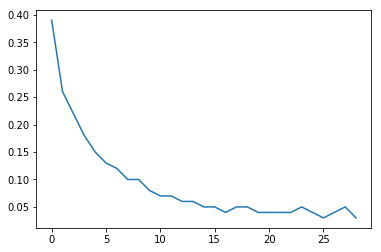

Plot for training and testing accuracy


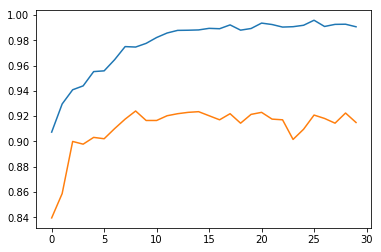

In [10]:
print('Plot for Epoch Loss')
plt.plot(stats['epoch_loss'][1:]) #To ignore the abnormal improvement in 1s epoch for a clear graph.
plt.show()
print('Plot for training and testing accuracy')
plt.plot(stats['trainacc'])
plt.plot(stats['testacc'])
plt.show()

In [14]:
print(max(stats['testacc']))
np.argmax(stats['testacc'])

0.9240641711229947


8

# Summary:

We achieve a maximum Test Accuracy of **92.4%** with pre-loaded CIFAR weights. It's at the learning rate of 0.01. We observed the training for 30 epochs. The maximum accuracy is acieved after **9 epochs** as shown in the orange line in the above graph.

Each epoch takes about 10.5 seconds on a Titan X GPU. The model is trained till saturation in training error. 

#### Training from scratch
Now we shall try training the model from scratch and observe the differences.

In [15]:
# Reinstantiate the model and optimizer
model = CustomResnet(num_classes = 10)
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)# Use Adam optimizer, use learning_rate hyper parameter
if(torch.cuda.is_available()):
    model.cuda()

criterion = nn.CrossEntropyLoss()# Define cross-entropy loss

# Train
stats1 = train(30)



Epoch # 0 Loss per batch:  1.19 Time in this epoch:  10.41
Test
Accuracy : 90.16042780748663
Training
Accuracy : 93.14109410229025
Epoch # 1 Loss per batch:  0.24 Time in this epoch:  10.4
Test
Accuracy : 90.42780748663101
Training
Accuracy : 94.32182271270915
Epoch # 2 Loss per batch:  0.2 Time in this epoch:  10.33
Test
Accuracy : 91.81818181818181
Training
Accuracy : 95.29488548712472
Epoch # 3 Loss per batch:  0.17 Time in this epoch:  10.79
Test
Accuracy : 91.81818181818181
Training
Accuracy : 96.1314821407381
Epoch # 4 Loss per batch:  0.14 Time in this epoch:  10.28
Test
Accuracy : 92.13903743315508
Training
Accuracy : 96.70701317194731
Epoch # 5 Loss per batch:  0.12 Time in this epoch:  10.33
Test
Accuracy : 92.3529411764706
Training
Accuracy : 97.4249436335588
Epoch # 6 Loss per batch:  0.11 Time in this epoch:  10.78
Test
Accuracy : 92.29946524064171
Training
Accuracy : 97.73347573276374
Epoch # 7 Loss per batch:  0.09 Time in this epoch:  10.28
Test
Accuracy : 92.7272727272

Plot for Epoch Loss


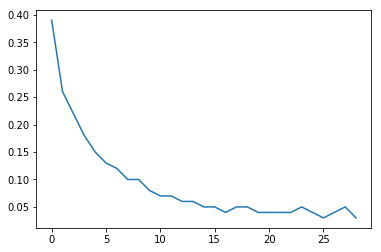

Plot for training and testing accuracy


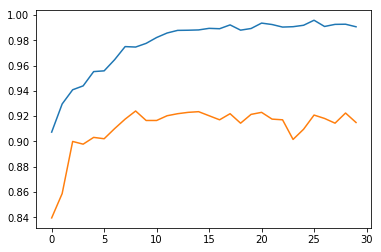

In [16]:
print('Plot for Epoch Loss')
plt.plot(stats['epoch_loss'][1:]) #To ignore the abnormal improvement in 1s epoch for a clear graph.
plt.show()
print('Plot for training and testing accuracy')
plt.plot(stats['trainacc'])
plt.plot(stats['testacc'])
plt.show()

In [18]:
print(max(stats1['testacc']))
np.argmax(stats1['testacc'])

0.9283422459893048


10

# Summary without CIFAR Weights

We achieve an accuracy of **92.8%** with 10 epochs. We train till 30 epochs for model to reach saturation. Each epoch takes about 10.2 seconds on a Titan X GPU. 

# Observation:

While CIFAR-100 weights provide a good initialization they hardly matter after training since the network can itself figure out, the most suitable set of weights. 

This is the end of Assignment 1